In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("darkgrid")

import common_functions as cf

## Import Data

In [2]:
df_all = pd.read_pickle("merged_df.pkl")

# Feature engineering (basic)

In [3]:
df_fe = cf.fe_basic_features(df_all)

# Feature engineering (Rolling)
rolling function takes an amount of directly preceding values to generate stuff like mean, median etc. So for my later input data, I don't need anything else than a set of preceding motion data.

In [4]:
ROLL_STEPS = 100

In [5]:
roll_df =  cf.fe_roll_features(df_fe,ROLL_STEPS)

## Data Splitting(Test/train)

In [6]:
train_df_roll,test_df_roll = cf.data_split_TrainTest(roll_df)

## Preprocess (Normalizing)

In [7]:
from sklearn.preprocessing import StandardScaler

for act_num in train_df_roll.action_num.unique():
    std = StandardScaler().set_output(transform='pandas')
    std.fit(train_df_roll.loc[train_df_roll.action_num == act_num,:"rotR_z_rmed"])
    train_df_roll.loc[train_df_roll.action_num == act_num,:"rotR_z_rmed"] = std.transform(train_df_roll.loc[train_df_roll.action_num == act_num,:"rotR_z_rmed"])


for act_num in test_df_roll.action_num.unique():
    std = StandardScaler().set_output(transform='pandas')
    std.fit(test_df_roll.loc[test_df_roll.action_num == act_num,:"rotR_z_rmed"])
    test_df_roll.loc[test_df_roll.action_num == act_num,:"rotR_z_rmed"] = std.transform(test_df_roll.loc[test_df_roll.action_num == act_num,:"rotR_z_rmed"])

In [8]:
#X_train_roll = cf.pre_normalize_tanh(X_train_roll)
#X_test_roll = cf.pre_normalize_tanh(X_test_roll)

## Modeling

### Split Data (Feature/Label)

In [9]:
X_train_roll,y_train_roll = cf.data_split_FeatLabel(train_df_roll)
X_test_roll,y_test_roll = cf.data_split_FeatLabel(test_df_roll)

### Neurel Network

In [45]:
from tensorflow import keras
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


import tensorflow as tf
import sklearn
tf.random.set_seed(20) # to fix the randomization
import numpy as np
np.random.seed(20)# to fix the randomizationin sklearn
sklearn.random.seed(1)

In [68]:
input_dim = X_train_roll.shape[1]
cnn = Sequential()
cnn.add(Dense(100, input_dim=input_dim, activation='relu'))
cnn.add(Dropout(rate =0.2)) # drop some of the neurals in the back prop. analysis to avoid overfitting
cnn.add(BatchNormalization())
cnn.add(Dense(40, activation='relu'))
cnn.add(Dropout(rate =0.5))
cnn.add(BatchNormalization())
cnn.add(Dense(20, activation='relu'))
cnn.add(Dropout(rate =0.2))
cnn.add(BatchNormalization())
cnn.add(Dense(1, activation='sigmoid'))

In [69]:
print(cnn.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 100)               5300      
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                                 
 batch_normalization_15 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_21 (Dense)            (None, 40)                4040      
                                                                 
 dropout_16 (Dropout)        (None, 40)                0         
                                                                 
 batch_normalization_16 (Bat  (None, 40)               160       
 chNormalization)                                     

In [70]:
opt = keras.optimizers.Adam(learning_rate=0.02)

cnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

X_train, val_X, y_train, val_y = train_test_split(X_train_roll, y_train_roll, shuffle=True,test_size=0.2 )

In [71]:
X_train_arr = np.asarray(X_train_roll)
y_train_arr = np.asarray(y_train_roll)
X_test_arr = np.asarray(X_test_roll)
y_test_arr = np.asarray(y_test_roll)
val_X =  np.asarray(val_X)
val_y =  np.asarray(val_y)

In [72]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [73]:
history = cnn.fit(X_train_arr, y_train_arr, epochs=150, batch_size=250,callbacks=[es,mc]
                  , validation_data=(val_X,val_y)
                  )


Epoch 1/150
116/117 [============================>.] - ETA: 0s - loss: 0.4624 - accuracy: 0.7699
Epoch 1: val_accuracy improved from -inf to 0.76486, saving model to best_model.h5
117/117 [==============================] - 7s 28ms/step - loss: 0.4618 - accuracy: 0.7703 - val_loss: 0.5138 - val_accuracy: 0.7649
Epoch 2/150
113/117 [===========================>..] - ETA: 0s - loss: 0.3437 - accuracy: 0.8526
Epoch 2: val_accuracy improved from 0.76486 to 0.89313, saving model to best_model.h5
117/117 [==============================] - 1s 10ms/step - loss: 0.3421 - accuracy: 0.8534 - val_loss: 0.2465 - val_accuracy: 0.8931
Epoch 3/150
112/117 [===========================>..] - ETA: 0s - loss: 0.3030 - accuracy: 0.8749
Epoch 3: val_accuracy did not improve from 0.89313
117/117 [==============================] - 1s 8ms/step - loss: 0.3019 - accuracy: 0.8751 - val_loss: 0.3056 - val_accuracy: 0.8751
Epoch 4/150
114/117 [============================>.] - ETA: 0s - loss: 0.2603 - accuracy: 0.89

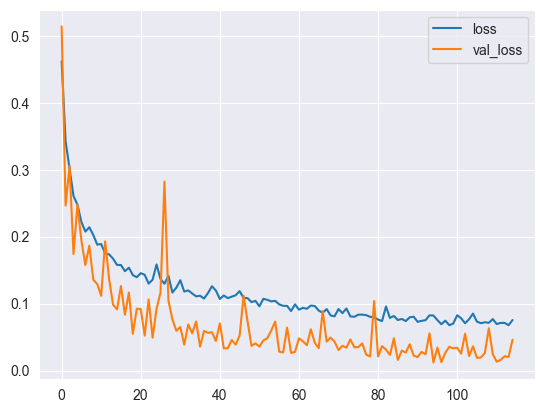

In [74]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss',"val_loss"]].plot()
plt.show()

#### Evaluation

- Evaluate best model which was monitored and saved

In [75]:
best_saved_model = load_model('best_model.h5')
_, train_acc = best_saved_model.evaluate(X_train_arr, y_train_arr, verbose=0)
_, test_acc = best_saved_model.evaluate(X_test_arr, y_test_arr, verbose=0)
print('Train: %.2f, Test: %.2f' % (train_acc*100, test_acc*100))

Train: 99.82, Test: 87.59


In [76]:

best_model_predictions = best_saved_model.predict(X_test_arr)
mae = round(mean_absolute_error(y_test_roll, best_model_predictions),3)
print("mean absolute error is",mae)

745/745 [==============================] - 4s 4ms/step
mean absolute error is 0.136


In [77]:
# convert predicted label rom analog to binary value
bin_best_model_predictions=[]
for val in best_model_predictions:
    if val >=0.5:
        bin_best_model_predictions.append(1)
    else:
        bin_best_model_predictions.append(0)

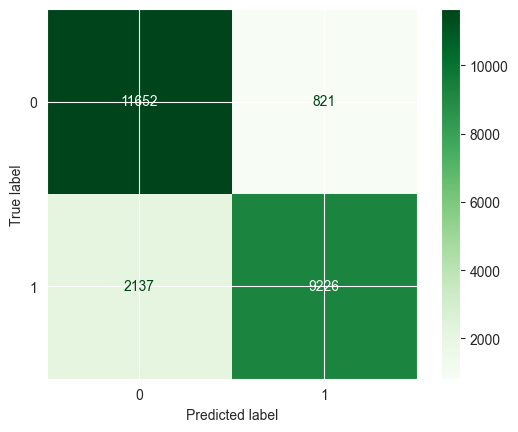

In [78]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(bin_best_model_predictions, y_test_roll)
conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
conf_mat_disp.plot(cmap='Greens')
plt.show()